In [26]:
import numpy as np
from rebin import rebin #pip install rebin
import matplotlib.pyplot as plt
import random
import h5py
from libsx import *
import pickle

np.random.seed = 42

In [27]:
nGasPower = 13

In [28]:
# filename of output file to be created
#foutbase = "SIC_"                                                     
#foutsuffix = ".dat"
#fout = foutbase + str(nGasPower).zfill(3) + foutsuffix

In [29]:
G = 6.6738e-8
MSun = 1.98892e33

In [30]:
# Disk properties (directly from Burkert & Bodenheimer 1993, see also Burkert et al. 1997, Springel 2005)
Ngas = 2**round(nGasPower)                      # The number of gas particles in the simulation
Mgas = MSun                                     # The mass of the cloud
rgas = 9.2e16                                     # The initial radius of the cloud in cm
omega = 7.2e-14                                 # The initial angular velocity of the cloud in radians s^-1 
rho0 = 6.02e-19                                 # The initial average density
cs = 1.9e4                                     # The sound speed

In [31]:
# Calculating derived quantities
tff = np.sqrt(3*np.pi/(32*G*rho0))                   # The free-fall time = 3.4e4 yr

In [32]:
# Setting the units of the simulation
unitMass_in_g = MSun                                                 # 1 solar mass
unitTime_in_s = tff                                                  # Scaling time to free-fall time
unitLength_in_cm = rgas                                              # Scaling distance to the initial cloud radius
unitVelocity_in_cm_per_s = unitLength_in_cm / unitTime_in_s          # The internal velocity unit

In [33]:
print(f'Unit_time_in_s = {round(unitTime_in_s, 2)} seconds')
print(f'Unit_time in kyrs = {round(unitTime_in_s/3600./24./365.25/1000., 2)} kyrs')
print(f'Unit_time in Myrs = {round(unitTime_in_s/3600./24./365.25/1e6, 4)} Myrs')

Unit_time_in_s = 2707545322236.16 seconds
Unit_time in kyrs = 85.8 kyrs
Unit_time in Myrs = 0.0858 Myrs


In [34]:
print(f'unitVelocity_in_cm_per_s = {round(unitVelocity_in_cm_per_s, 2)} cm/s')

unitVelocity_in_cm_per_s = 33979.12 cm/s


In [35]:
# calling things to code units

rgas /= unitLength_in_cm
Mgas /= unitMass_in_g
omega *= unitTime_in_s

In [36]:
# Making a uniform grid of particles from which I will carve a sphere
# with Ngas particles.

regular_grid = False

if regular_grid:
    ninds = max((15,2*round(((1.1*Ngas)*3./4/np.pi)**.333333333)))              # Size of grid template
    
    inds = np.arange(ninds)-np.floor(ninds/2)
    
    zarr, yarr, xarr = np.mgrid[inds[0]:inds[-1]:ninds+0j, inds[0]:inds[-1]:ninds+0j, inds[0]:inds[-1]:ninds+0j]
    
    gridInds=np.array(range(len(xarr)))
    
    xarr = xarr.flatten().reshape(1, -1)
    yarr = yarr.flatten().reshape(1, -1)
    zarr = zarr.flatten().reshape(1, -1)

    pos = np.transpose(np.concatenate([xarr, yarr, zarr]))

    rarr = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5       # vector of distance from origin to grid points 
    
    nsrt = (np.argsort(rarr))[:Ngas-1]  # Indices for Ngas points closest to origin (carving sphere !!!)
    rsrt = rarr[nsrt]
    
    if max(rsrt) > ninds/2:
        print('Must increase ninds!') # You're trying to simulate a cloud with a very large number of particles.
                                      # Increase ninds if you want this error to go away.
    
    pos = pos[nsrt, :] # Position of particles in sphere
    
    pos *= rgas/max(rsrt)  #Scaling particle positions to where I want them to be in the simulation
    
    r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5

else:
    
    r = np.random.random(Ngas)*rgas
    u = np.random.random(Ngas)*2 - 1
    theta = np.random.random(Ngas)*2*np.pi

    xt = (r**(1./3.) * (1. - u**2)**0.5 * np.cos(theta)).reshape(1, -1)
    yt = (r**(1./3.) * (1. - u**2)**0.5 * np.sin(theta)).reshape(1, -1)
    zt = (r**(1./3.) * u).reshape(1, -1)

    pos = np.transpose(np.concatenate([xt, yt, zt]))
    # Shouldn't we also normalize this one !!!!!??????



## Calculating particle velocities in rectangular coordinates

In [37]:
# rxy = (pos[:,0]**2 + pos[:,1]**2)**0.5
vel = np.zeros_like(pos)

print(vel.shape, pos.shape, r.shape)

vel[:,0] = -omega*pos[:,1]
vel[:,1] = omega*pos[:,0]
vel[:,2] = 0

wh = np.argwhere(np.isnan(vel))
if len(wh) > 0:
    vel[wh] = 0.0


(8192, 3) (8192, 3) (8192,)


## Calculating particle masses

In [38]:
mp = Mgas / pos.shape[0]

# Imposing an m=2 density perturbation with an amplitude of 10 percent.
#masses = mp * (1 + .5*((pos[:, 0]/rxy)**2 - (pos[:, 1]/rxy)**2))
masses = mp * np.ones(pos.shape[0])
#boxsize = rgas/unitLength_in_cm

#wh = np.argwhere(np.isnan(masses)) # Fixes an issue with the particle at the origin
#if len(wh) > 0:
#    masses[wh] = mp

In [39]:
# Assign particle sound speed (isothermal EOS)
u = np.zeros(len(masses)) + cs**2 / unitVelocity_in_cm_per_s**2

## Create header

In [40]:
#write intial conditions file

ids = np.arange(pos.shape[0])

FloatType = np.float32  # double precision: np.float64, for single use np.float32
IntType = np.int32

IC = h5py.File('hfv_ic.hdf5', 'w')

## create hdf5 groups
header = IC.create_group("Header")
part0 = IC.create_group("PartType0")

## header entries
NumPart = np.array([pos.shape[0]], dtype=IntType)
header.attrs.create("NumPart_ThisFile", NumPart)
header.attrs.create("NumPart_Total", NumPart)
header.attrs.create("NumPart_Total_HighWord", np.zeros(1, dtype=IntType) )
header.attrs.create("MassTable", np.zeros(1, dtype=IntType) )
header.attrs.create("Time", 0.0)
header.attrs.create("Redshift", 0.0)
header.attrs.create("BoxSize", 0)
header.attrs.create("NumFilesPerSnapshot", 1)
header.attrs.create("Omega0", 0.0)
header.attrs.create("OmegaB", 0.0)
header.attrs.create("OmegaLambda", 0.0)
header.attrs.create("HubbleParam", 1.0)
header.attrs.create("Flag_Sfr", 0)
header.attrs.create("Flag_Cooling", 0)
header.attrs.create("Flag_StellarAge", 0)
header.attrs.create("Flag_Metals", 0)
header.attrs.create("Flag_Feedback", 0)
if pos.dtype == np.float64:
    header.attrs.create("Flag_DoublePrecision", 1)
else:
    header.attrs.create("Flag_DoublePrecision", 0)

## copy datasets
part0.create_dataset("Coordinates", data=pos)
part0.create_dataset("Velocities", data=vel)
part0.create_dataset("ParticleIDs", data=ids )
part0.create_dataset("Masses", data=masses)
part0.create_dataset("InternalEnergy", data=u)

IC.close()

In [41]:
pos.shape

(8192, 3)

In [42]:
print('Done !')

Done !


In [43]:
t = 2.0

np.cos(2.*t)

-0.6536436208636119

In [44]:
np.cos(t)**2 - np.sin(t)**2

-0.6536436208636119

In [45]:
h = do_smoothingX((pos, pos))

In [46]:
dictx = {'r': pos, 'v': vel, 'h': h, 'm': masses,
         'unitVelocity': unitVelocity_in_cm_per_s,
         'unitTime': unitTime_in_s}

num = str(int(np.floor(pos.shape[0]/1000)))

with open('hfv_IC_RND_' + num +'k.pkl', 'wb') as f:
    pickle.dump(dictx, f)

## Plot the particles

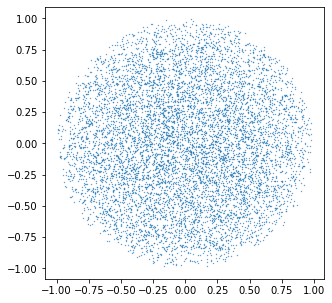

In [47]:
plt.figure(figsize = (5,5))
plt.scatter(pos[:, 0], pos[:, 1], s = 0.1);

## Density profile

In [48]:
#-------- rho ---------
rho = getDensity(pos, masses, h)

rho_crit = 1e-13
rho = rho_crit * rho

In [49]:
rr = (pos[:, 0]*pos[:, 0] + pos[:, 1]*pos[:, 1] + pos[:, 2]*pos[:, 2])**0.5

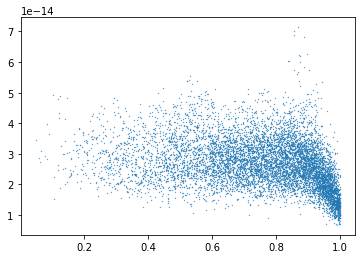

In [50]:
plt.scatter(rr, (rho), s = 0.1);